In [1]:
import math
import time
from functools import partial
from collections import namedtuple

import numpy as np
from tqdm.notebook import tqdm
import vegasflow as vflow
import vegas, gvar
from scipy.special import erf
import tensorflow as tf
import tensorflow_probability as tfp

from iflow.integration import integrator
from iflow.integration import couplings

import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

### Определяем подынтегральную функцию

In [98]:
@tf.function
#     input_signature = [tf.TensorSpec(shape=[None,2], dtype=tf.float64),
#                                tf.TensorSpec(shape=[], dtype=tf.float64),
#                                tf.TensorSpec(shape=[2,1], dtype=tf.float64)])
def j_integrand(r, w, n):
    """"""
    # n = params['n']
    
    x = tf.reshape(r[:, 0], shape=(-1,1))
    y = tf.reshape(r[:, 1], shape=(-1,1))
        
    real = -x ** 2 - y ** 2
    imag = w * tf.tensordot(r, n, axes=1)   
    
    res = tf.exp(tf.complex(real, imag))
    res = tf.math.real(res)
#     res = tf.reshape(res, shape=(r.shape[0],1))
    res = tf.reshape(res, shape=(-1,))
    
    return res


# test
r = tf.random.uniform([6, 2], dtype=tf.float64)
w = tf.constant(0.1, dtype=tf.float64)
n = tf.constant([1, 0], shape=(2,1), dtype=tf.float64)
# params = { 'n': tf.constant([1, 0], shape=(2,1), dtype=tf.float64) }

j_integrand(r, w, n)

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.88205873, 0.85854243, 0.98424415, 0.41518549, 0.44363271,
       0.64494123])>

In [99]:
j_integrand.input_signature

### Определяем аналитическое решение

In [112]:
@tf.function
def analytic_solution(w, params):
    """"""
    pi = tf.constant(math.pi, dtype=tf.float64)
    
    return pi * tf.exp(-w ** 2 / 4)
    
    
# test
w = tf.constant(0.1, dtype=tf.float64)
params = { 'n': tf.constant([1, 0], shape=(2,1), dtype=tf.float64) }

analytic_solution(w, params).numpy()

3.133748481256741

In [181]:
tf.constant(math.pi, dtype=tf.float64) * tf.exp(-w ** 2 / 4)

<tf.Tensor: shape=(), dtype=float64, numpy=3.133748481256741>

In [184]:
math.pi * math.exp(-0.1 ** 2 / 4)

3.133748481256741

### Plot

In [185]:
def np_integrand(r):
    """"""    
    x = r[0]
    y = r[1]
        
    real = -x ** 2 - y ** 2
    imag = w * np.dot(r, n)   
    
    res = np.exp(np.complex(real, imag))
    res = np.real(res)
    
    return res

In [186]:
data = np.random.uniform(low=-10, high=10, size=(100,2))

In [187]:
yy = np.asarray([np_integrand(x) for x in data])

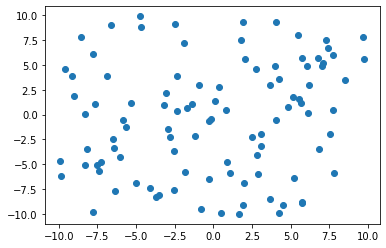

In [188]:
plt.scatter(data[:, 0], data[:, 1])

In [189]:
import seaborn as sns

<AxesSubplot:>

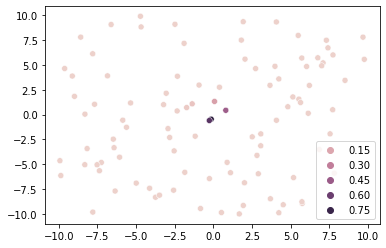

In [190]:
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=yy)

### nquad

In [200]:
from scipy.integrate import nquad

In [208]:
w = 0.1
n = np.array([1, 0])


def nquad_np_integrand(x, y):
    """"""
    real = -x ** 2 - y ** 2
    imag = w * np.dot(np.array([x,y]), n)   
    
    res = np.exp(np.complex(real, imag))
    #res = np.real(res)
    
    #res = np.exp(real) * np.cos(imag)
    
    return res


nquad(nquad_np_integrand,
      [[-1,1], [-1,1]],
      full_output=True)

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\scipy\integrate\quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(2.228156338772748, 2.473750469769995e-14, {'neval': 441})

### vegas

In [202]:
w = 0.1
n = np.array([1, 0])
integ = vegas.Integrator([[-1, 1], [-1, 1]])


def np_integrand(r):
    """"""    
    x = r[0]
    y = r[1]
        
    real = -x ** 2 - y ** 2
    imag = w * np.dot(r, n)   
    
    #res = np.exp(np.complex(real, imag))
    #res = np.real(res)
    
    res = np.exp(real) * np.cos(imag)
    
    return res


# test
np_integrand([1,1])

0.134659170529511

In [196]:
integ(np_integrand, nitn=10, neval=10000)           # adapt the grid

2.22825(12)

In [197]:
result = integ(np_integrand, nitn=20, neval=10000)  # estimate the integral

In [198]:
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.22822(25)     2.22822(25)         0.00     1.00
  2   2.22826(21)     2.22824(16)         0.02     0.89
  3   2.22802(19)     2.22815(12)         0.43     0.65
  4   2.22811(16)     2.228135(97)        0.30     0.83
  5   2.22801(14)     2.228095(81)        0.35     0.84
  6   2.22801(13)     2.228070(68)        0.35     0.88
  7   2.22823(11)     2.228111(58)        0.53     0.79
  8   2.228231(99)    2.228142(50)        0.61     0.75
  9   2.228221(88)    2.228161(44)        0.61     0.77
 10   2.228045(86)    2.228137(39)        0.71     0.70
 11   2.228121(80)    2.228134(35)        0.64     0.78
 12   2.228164(73)    2.228140(32)        0.59     0.84
 13   2.228202(63)    2.228153(28)        0.61     0.84
 14   2.228215(54)    2.228166(25)        0.64     0.82
 15   2.228124(50)    2.228157(22)        0.64     0.84
 16   2.228183(45)    2.228162(20)        0.61  

In [53]:
epochs = 1000
ptspepoch = 5000

In [59]:
vegas_calls = []
vegas_results = []
vegas_means = []
vegas_stddevs = []

first_run = True

print(f"--> Starting Vegas..")
start = time.time()

epoch = 0
current_vegas_precision = 1e99
while current_vegas_precision > target_precision:
    current_result = integ(np_integrand, nitn=1, neval=ptspepoch)
    vegas_means.append(current_result.mean)
    vegas_stddevs.append(current_result.sdev)
    vegas_results.append(current_result)

    _, current_vegas_precision = variance_weighted_result(np.array(vegas_means),
                                                          np.array(vegas_stddevs))
    if epoch % 10 == 0:
        print('Epoch: {:3d} Integral = '
              '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, current_result.mean,
                                                                 current_result.sdev,
                                                                 current_vegas_precision))

--> Starting Vegas..
Epoch:   0 Integral = 3.128374e+00 +/- 3.372692e-03 Total uncertainty = 3.372692e-03
Epoch:   0 Integral = 3.137065e+00 +/- 3.274734e-03 Total uncertainty = 2.349455e-03
Epoch:   0 Integral = 3.127832e+00 +/- 3.969165e-03 Total uncertainty = 2.021806e-03
Epoch:   0 Integral = 3.131362e+00 +/- 3.806915e-03 Total uncertainty = 1.785609e-03
Epoch:   0 Integral = 3.135972e+00 +/- 3.566719e-03 Total uncertainty = 1.596694e-03
Epoch:   0 Integral = 3.131094e+00 +/- 3.695343e-03 Total uncertainty = 1.465724e-03
Epoch:   0 Integral = 3.131710e+00 +/- 3.497502e-03 Total uncertainty = 1.351816e-03
Epoch:   0 Integral = 3.136343e+00 +/- 3.126418e-03 Total uncertainty = 1.240795e-03
Epoch:   0 Integral = 3.137743e+00 +/- 3.882870e-03 Total uncertainty = 1.181915e-03
Epoch:   0 Integral = 3.129821e+00 +/- 3.533460e-03 Total uncertainty = 1.120873e-03
Epoch:   0 Integral = 3.138993e+00 +/- 4.098666e-03 Total uncertainty = 1.081173e-03
Epoch:   0 Integral = 3.131843e+00 +/- 2.996

KeyboardInterrupt: 

### vegasflow

Параметры интегранда

In [148]:
w = tf.constant(0.1, dtype=tf.float64)
n = tf.constant([1, 0], shape=(2,1), dtype=tf.float64)
# params = { 'n': tf.constant([1, 0], shape=(2,1), dtype=tf.float64) }

Аналитическое решение

In [149]:
target = analytic_solution(w, params).numpy()
target_precision = 1e-4 * target

target

3.133748481256741

Численное решение

In [150]:
# n_events = 10000

In [151]:
tf_spec = tf.TensorSpec(shape=[None,2], dtype=tf.float64)
tf_spec

TensorSpec(shape=(None, 2), dtype=tf.float64, name=None)

In [152]:
@tf.function  #(input_signature=[tf_spec])
def tf_integrand(x):
    
#     x = tf.reshape(r[:, 0], shape=(-1,1))
#     y = tf.reshape(r[:, 1], shape=(-1,1))
        
#     real = -x ** 2 - y ** 2
#     imag = w * tf.tensordot(r, n, axes=1)   
    
#     res = tf.exp(tf.complex(real, imag))
#     res = tf.math.real(res)
#     return res
    
#     return tf.reshape(x[:, 0], shape=(-1,1))
    
    return j_integrand(x, w=w, n=n)


# test
tf_integrand(tf.random.uniform(shape=(5, 2), minval=-10, maxval=10, dtype=tf.float64))

<tf.Tensor: shape=(5,), dtype=float64, numpy=
array([4.26157143e-28, 4.11041073e-47, 5.51873622e-39, 1.90047881e-19,
       6.94024898e-11])>

In [153]:
tf_integrand.input_signature

In [154]:
n_dim = 2
n_events = int(1e6)
events_limit = int(1e7)

vegas_integ = vflow.VegasFlow(n_dim,
                              n_events,
                              events_limit=events_limit,
                              verbose=False, signature=True)
vegas_integ.compile(tf_integrand,
                    compilable=True,
#                     signature=[tf_spec],
                    trace=False)

In [155]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [156]:
result_tuple = namedtuple('result_tuple', ['mean', 'sdev'])

vegas_calls = []
vegas_results = []
vegas_means = []
vegas_stddevs = []

epoch = 0
current_vegas_precision = 1e99
while current_vegas_precision > target_precision:
    current_result = vegas_integ.run_integration(n_iter=1)
    current_result = result_tuple(*current_result)

    vegas_means.append(current_result.mean)
    vegas_stddevs.append(current_result.sdev)
    vegas_results.append(current_result)

    _, current_vegas_precision = variance_weighted_result(np.array(vegas_means),
                                                          np.array(vegas_stddevs))
    if True or epoch % 1 == 0:
        print('[VegasFlow] Epoch: {:3d} Integral = '
              '{:8e} +/- {:8e} Total uncertainty = {:8e} (?>) {:8e}'
              .format(epoch, current_result.mean,
                      current_result.sdev,
                      current_vegas_precision,
                      target_precision))
    epoch += 1

[VegasFlow] Epoch:   0 Integral = 5.565950e-01 +/- 2.162073e-04 Total uncertainty = 2.162073e-04 (?>) 3.133748e-04


Значение интеграла

In [157]:
current_result.mean

0.5565949694157697

### Crude MC

In [159]:
%%time

npts = int('25,000,000'.replace(',', ''))
pts = tf.random.uniform(
    shape=(npts, n_dim),
    minval=-1,
    maxval=1,
    dtype=tf.float64,
    seed=77,
)
value = tf_integrand(pts)

format_string = ('Crude MC in {:d} dimensions based on '
                 '{:d} points: {:.3e} +/- {:.3e}')
print(format_string.format(n_dim, npts,
                           tf.math.reduce_mean(value).numpy(),
                           tf.math.reduce_std(value).numpy() / np.sqrt(npts)))

Crude MC in 2 dimensions based on 25000000 points: 5.570e-01 +/- 4.326e-05
Wall time: 595 ms


### i-flow (не работает, появляются nans при семплинге)

In [160]:
epochs = 1000
ptspepoch = 5000
target_precision = 1e-4 * target

target_precision

0.00031337484812567413

In [161]:
def build_iflow(func, ndims, low, high):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    bijector = []
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                             num_bins=16,
                                                             blob=None,
                                                             options=None))
    bijector = tfb.Chain(list(reversed(bijector)))
    # low = np.zeros(ndims, dtype=np.float64)
    # high = np.ones(ndims, dtype=np.float64)
    low = np.repeat(low, ndims).astype(np.float64)
    high = np.repeat(high, ndims).astype(np.float64)
    dist = tfd.Uniform(low=low, high=high, allow_nan_stats=False)
    dist = tfd.Independent(distribution=dist,
                           reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    integrate = integrator.Integrator(
        func, dist, optimizer,
#         loss_func='exponential',
        loss_func='kl'
    )

    return integrate

In [162]:
# integrate = None

import gc
gc.collect()

748

In [163]:
# integrate.dist.sample(10)

In [164]:
# integrate.dist.log_prob(tf.constant([1, 10, 100, 1000,10000], shape=(5,1), dtype=tf.float64))

In [165]:
def build(in_features, out_features, options):
    """ Builds a dense NN.

    The output layer is initialized to 0, so the first pass
    before training gives the identity transformation.

    Arguments:
        in_features (int): dimensionality of the inputs space
        out_features (int): dimensionality of the output space
        options: additional arguments, not used at the moment

    Returns:
        A tf.keras.models.Model instance

    """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features, bias_initializer='zeros',
                                    kernel_initializer='zeros')(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [168]:
def train_iflow_target(integrate, ptspepoch, target):
    """ Run the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        target (float): target precision of final integral

    Returns:
        numpy.ndarray(float): integral estimations and its uncertainty of each epoch

    """
    means = []
    stddevs = []
    current_precision = 1e99
    epoch = 0
    while current_precision > target:
        loss, integral, error = integrate.train_one_step(ptspepoch, integral=True)
        means.append(integral)
        stddevs.append(error)
        
        _, current_precision = variance_weighted_result(np.array(means), np.array(stddevs))

        ###
        loss = loss.numpy()
        integral = integral.numpy()
        error = error.numpy()
        ###
        
#         print(epoch, loss, integral, error, current_precision)

        if epoch % 10 == 0:
            print('[i-flow] Epoch: {:3d} Loss = {:8e} Integral = '
                  '{:8e} +/- {:8e} Total uncertainty = {:8e}'
                  .format(epoch, loss, integral, error, current_precision))
        epoch += 1
    return np.array(means), np.array(stddevs)


# test
integrate = build_iflow(tf_integrand, n_dim, low=-1, high=1)
train_iflow_target(integrate, ptspepoch, target_precision)

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_160 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_161 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_162 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_163 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_164 (Dense)            (None, 49)                1617      
Total params: 4,849
Trainable params: 4,849
Non-trainable params: 0
________________________________________________________

[i-flow] Epoch: 520 Loss = 1.406743e+00 Integral = 5.548850e-01 +/- 1.398276e-02 Total uncertainty = 7.388774e-04
[i-flow] Epoch: 530 Loss = 1.345763e+00 Integral = 5.868122e-01 +/- 1.417392e-02 Total uncertainty = 7.288246e-04
[i-flow] Epoch: 540 Loss = 1.397188e+00 Integral = 5.585788e-01 +/- 1.396682e-02 Total uncertainty = 7.190122e-04
[i-flow] Epoch: 550 Loss = 1.409703e+00 Integral = 5.463035e-01 +/- 1.374323e-02 Total uncertainty = 7.096259e-04
[i-flow] Epoch: 560 Loss = 1.374994e+00 Integral = 5.655622e-01 +/- 1.389161e-02 Total uncertainty = 7.006350e-04
[i-flow] Epoch: 570 Loss = 1.382735e+00 Integral = 5.692478e-01 +/- 1.409196e-02 Total uncertainty = 6.918977e-04
[i-flow] Epoch: 580 Loss = 1.372868e+00 Integral = 5.725138e-01 +/- 1.404714e-02 Total uncertainty = 6.835509e-04
[i-flow] Epoch: 590 Loss = 1.411235e+00 Integral = 5.464961e-01 +/- 1.379208e-02 Total uncertainty = 6.753803e-04
[i-flow] Epoch: 600 Loss = 1.393738e+00 Integral = 5.576038e-01 +/- 1.392595e-02 Total u

[i-flow] Epoch: 1240 Loss = 1.418305e+00 Integral = 5.414272e-01 +/- 1.361688e-02 Total uncertainty = 4.228441e-04
[i-flow] Epoch: 1250 Loss = 1.377157e+00 Integral = 5.652192e-01 +/- 1.384354e-02 Total uncertainty = 4.208830e-04
[i-flow] Epoch: 1260 Loss = 1.407885e+00 Integral = 5.485501e-01 +/- 1.367693e-02 Total uncertainty = 4.189290e-04
[i-flow] Epoch: 1270 Loss = 1.379093e+00 Integral = 5.626904e-01 +/- 1.377479e-02 Total uncertainty = 4.169800e-04
[i-flow] Epoch: 1280 Loss = 1.400868e+00 Integral = 5.517816e-01 +/- 1.370511e-02 Total uncertainty = 4.151009e-04
[i-flow] Epoch: 1290 Loss = 1.402725e+00 Integral = 5.522237e-01 +/- 1.373986e-02 Total uncertainty = 4.132244e-04
[i-flow] Epoch: 1300 Loss = 1.390364e+00 Integral = 5.597506e-01 +/- 1.381615e-02 Total uncertainty = 4.113510e-04


ValueError: setting an array element with a sequence.

In [ ]:
# integrate.train_one_step(ptspepoch, integral=True)

In [25]:
params_dict = {}
params_dict['i_flow'] = {}


print('\n')

print('[i-flow] BUILD\n')
start = time.time()
integrate = build_iflow(tf_integrand, ndims, low=-10, high=10)
end = time.time()
print(f"[i-flow] BUILD time: {(end-start):.4f} s\n")

params_dict['i_flow']['build_time'] = end - start



[i-flow] BUILD

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 49)                1617      
Total params: 4,849
Trainable params: 4,849
Non-trainable params: 0
_______________________________________

In [26]:
print('[i-flow] START\n')
start = time.time()
mean_t, err_t = train_iflow_target(integrate, ptspepoch, target_precision)
end = time.time()
print(f"[i-flow] END time: {int(end-start)} s\n")

params_dict['i_flow']['run_time'] = end - start

num_epochs = len(mean_t)
x_values = np.arange(ptspepoch, (num_epochs+1) * ptspepoch, ptspepoch)
iflow_mean_wgt, iflow_err_wgt = variance_weighted_result(mean_t, err_t)

print("[i-flow] Results for {:d} dimensions:\n".format(ndims))
print("[i-flow] Weighted iflow result is {:.5e} +/- {:.5e}.\n".format(
    iflow_mean_wgt, iflow_err_wgt))
print("[i-flow] Relative Uncertainty iflow result is {:.3f}\n".format(
    rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.)))
print("[i-flow] i-flow needed {:d} epochs and {:d} function calls\n".format(
    num_epochs,
    num_epochs*ptspepoch
))

params_dict['i_flow']['w_mean'] = float(iflow_mean_wgt)
params_dict['i_flow']['w_err'] = float(iflow_err_wgt)
params_dict['i_flow']['rel_unc'] = float(rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.))
params_dict['i_flow']['res_epochs'] = num_epochs
params_dict['i_flow']['res_calls'] = num_epochs * ptspepoch

[i-flow] START

(5000,) (5000,) (5000,) (5000,)
(5000,) (5000,) (5000,) (5000,)
[i-flow] Epoch:   0 Loss = 1.482576e-01 Integral = 2.274504e+02 +/- 1.579470e+00 Total uncertainty = 1.579470e+00
[i-flow] Epoch:  10 Loss = 4.904286e-02 Integral = 4.207071e+02 +/- 1.669551e+00 Total uncertainty = 4.868081e-01
[i-flow] Epoch:  20 Loss = 4.021437e-02 Integral = 4.194795e+02 +/- 1.486702e+00 Total uncertainty = 3.480318e-01
[i-flow] Epoch:  30 Loss = 3.520691e-02 Integral = 3.926697e+02 +/- 1.270078e+00 Total uncertainty = 2.676398e-01
[i-flow] Epoch:  40 Loss = 3.523485e-02 Integral = 3.913282e+02 +/- 1.277046e+00 Total uncertainty = 2.223108e-01
[i-flow] Epoch:  50 Loss = 3.369508e-02 Integral = 3.922016e+02 +/- 1.255163e+00 Total uncertainty = 1.948304e-01
[i-flow] Epoch:  60 Loss = 2.781082e-02 Integral = 3.904077e+02 +/- 1.140870e+00 Total uncertainty = 1.743145e-01
[i-flow] Epoch:  70 Loss = 3.051479e-02 Integral = 3.835051e+02 +/- 1.172740e+00 Total uncertainty = 1.582839e-01
[i-flow]

In [27]:
params_dict

{'i_flow': {'build_time': 0.11868119239807129,
  'run_time': 5.336259126663208,
  'w_mean': nan,
  'w_err': nan,
  'rel_unc': nan,
  'res_epochs': 179,
  'res_calls': 895000}}

In [28]:
data = integrate.sample(500).numpy()

E:\_MAGISTER_ACE\Наука\test-env\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
E:\_MAGISTER_ACE\Наука\test-env\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

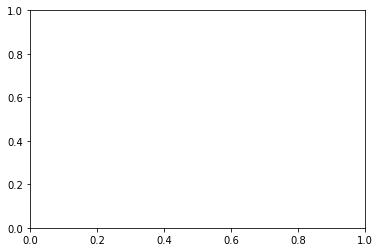

In [29]:
plt.hist(data);